# JWST NIRISS SIRS Correction

Bernard J. Rauscher<br>
NASA Goddard Space Flight Center, Greenbelt, MD 20771<br>

29 July 2021

This example shows how to SIRS correct JWST NIRISS full-frame data using a previously computed SIRS calibration file. Chris Willott of the NIRISS team specified which files to use in an email dated 26 July 2021. The data set consisted of 48 sampled up-the-ramp full-frame darks, each having 100 frames. I used the first half, sorted by exposure starting time, as training data. I used the second half to test SIRS.

## 1. Load the Previously Computed Calibration file.

We start by loading the previously computed SIRS calibration file. We plot $\alpha$ and $\beta$ to show that they are reasonable. Broadly speaking, we expect to see $\alpha$ take most of the weight in output \#0 and $\beta$ take most of the weight in output \#3. We expect the other two outputs to be intermediate.

In [1]:
# Standard python packages
from glob import glob
from astropy.io import fits
import pandas as pd
import numpy as np
from os import getenv
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from matplotlib import cm

import sirspy

In [2]:
# Instantiate a SIRS object
sirs = sirspy.SIRS(getenv('HOME')+'/Library/JWST/NIRISS/20160105_niriss_sirs_first-24.h5')

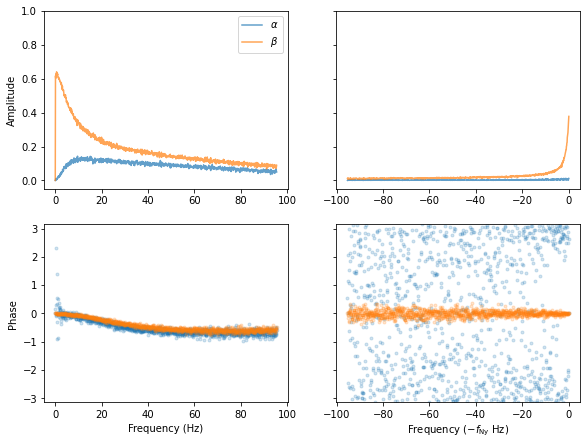

In [6]:
# Make some plots to show that it imported correctly. NIRISS's outputs are
# numbered 0-3 in SIRS.
output = 3 # Select an output from the set {0,1,2,3}
sirs.plot(output, mag=1.5); # Plot it

## 2. SIRS Correct One File

The file names do not naturally sort by time. We therefore need a little helper function to sort filenames by integration start time.

In [12]:
def sort_fits(files):
    """
    Sort a list of FITS files by integration start time
    
    Parameters: files, list
                  A list of FITS files to sort
    """
    # Tabulate pathnames and timestamps
    ts = []
    for file in files:    
        with fits.open(file) as hdul:
            _ts = hdul[0].header['DATE-OBS']+'T'+hdul[0].header['TIME-OBS']
            _ts = pd.to_datetime(_ts)
            ts.append(_ts)
        
    # Create a pandas DataFrame
    df = pd.DataFrame({'File':pd.Series(files), 'TS':pd.Series(ts)})
    
    # Sort by time
    df = df.sort_values('TS')
    
    # Done
    return(df['File'].values)

Reference correct one that was not part of the training data set.

In [13]:
# Make a time sorted list of files. The last 24 were excluded from the training set.
# These can be used to test SIRS.
files = sort_fits(glob('/local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/*.fits'))[-24:]

In [14]:
# Pick one from the list
file = files[0]

In [15]:
# Get data and convert to float
with fits.open(file) as hdul:
    D = np.float64(hdul[0].data)

In [16]:
# Reference correct
sirs.refcor(D)

## 3. "Slope Fitting" the SIRS Corrected Cube

In [13]:
Λ = sirspy.Legendre(100,1) # 100 samples up-the-ramp, 1st degree fit

In [14]:
λ = 2*Λ.legfit(D)[1] # Keep just integrated counts in DN

In [15]:
fits.PrimaryHDU(λ).writeto(getenv('HOME')+'/tmp/myfit.fits', overwrite=True)

## 4. "Slope Fit" them all and save just the slope  images.

The units are DN. The next two cells are time consuming. I have set their type to `Raw` so that they do not execute.

## 5. Difference Between SIRS and Rows-Only

The analysis done in Section 4 is time consuming. I therefore load the previously computed results here.

In [2]:
# Read data back in
ddir = getenv('HOME')+'/tmp/'
with fits.open(ddir+'20210728_niriss_sirs_counts.fits') as hdul:
    D_sirs = hdul[0].data
with fits.open(ddir+'20210727_niriss_rows_counts.fits') as hdul:
    D_rows = hdul[0].data

In [20]:
# Compute the difference
δ = D_sirs - D_rows

In [23]:
# Save
fits.PrimaryHDU(δ).writeto(ddir+'20210728_niriss_diff_counts.fits')

## 6. Make PNG images for a Movies Blink through Slope Images

A "slope images" is the result of least-squares fitting straight lines to all pixels and multiplying the slope term by the integration time. It gives the integrated charge during the exposure in units of digital numbers, DN.

I ran the above once. The median value is 27 DN. Look 5 DN on either side.

The following cells make sets of PNG images. In unix, `ffmpeg` can be used to make movies as follows.

`ffmpeg -f image2 -framerate .05 -i <prefix>_%02d.png -s 1920x1080 -vcodec libx264 -pix_fmt yuv420p -q:v 0 <prefix>.mov`

This image size is appropriate for high definition TV display. 

In [17]:
# Define a little helper
def prep(D):
    zrange = (27-5,27+5) # DN
    # _D = D[:1080,:1920].copy() # HDTV format
    _D = D.copy()
    _D[_D<zrange[0]] = zrange[0]
    _D[_D>zrange[1]] = zrange[1]
    _D -= zrange[0]
    _D = np.uint8(255*_D/_D.max())
    return(_D[::-1])

In [18]:
# Do the SIRS processed files
for i in np.arange(len(files)):
    im = Image.fromarray(prep(D_sirs[i]))
    ofile = getenv('HOME')+'/tmp/sirs_'+'{:02d}'.format(i)+'.png'
    im.save(ofile)

In [19]:
# Do the rowsonly processed files
for i in np.arange(len(files)):
    im = Image.fromarray(prep(D_rows[i]))
    ofile = getenv('HOME')+'/tmp/rows_'+'{:02d}'.format(i)+'.png'
    im.save(ofile)

In [20]:
# Define another little helper
def prep1(D):
    zrange = (-5,+5) # Range in DN
    _D = D.copy()
    _D -= np.median(D)
    _D[_D<zrange[0]] = zrange[0]
    _D[_D>zrange[1]] = zrange[1]
    _D -= zrange[0]
    _D = np.uint8(255*_D/_D.max())
    return(_D[::-1])

In [21]:
# Do some side by side
for i in np.arange(len(files)):
    l = D_rows[i,:1080,:960]
    r = np.fliplr(D_sirs[i,:1080,:960])
    here = np.zeros((1080,1920), dtype=np.float)
    here[:,:960] = l
    here[:,960:] = r
    here[:,958:958+5] = 255 # White line down center
    im = Image.fromarray(prep1(here))
    ofile = getenv('HOME')+'/tmp/comp_'+'{:02d}'.format(i)+'.png'
    im.save(ofile)